In [25]:
import re
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [46]:
classes = {"lenses": 0, "nonlenses": 1}
reverseclasses = {0: "lenses", 1: "nonlenses"}
dataset_dir = "dataset"

imgList, classList = [], []
for clas in classes.keys():
    main_dir = os.path.join(dataset_dir, f"train_{clas}")
    listDir = os.listdir(main_dir)

    listDir = sorted(listDir, key=lambda x: int(re.search(r"(\d+).npy", x).group(1)))
    
    for idx, item in enumerate(listDir):
        if idx >= 1730:
            break
        img = np.load(os.path.join(main_dir, item))
        imgList.append(img)
        classList.append(classes[clas])

imgList = np.array(imgList, dtype=np.float32)
classList = np.array(classList, dtype=np.int8)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(imgList, classList, test_size=0.1)

trainDataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.int32))
valDataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.int32))

batchSize = 32
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=batchSize)

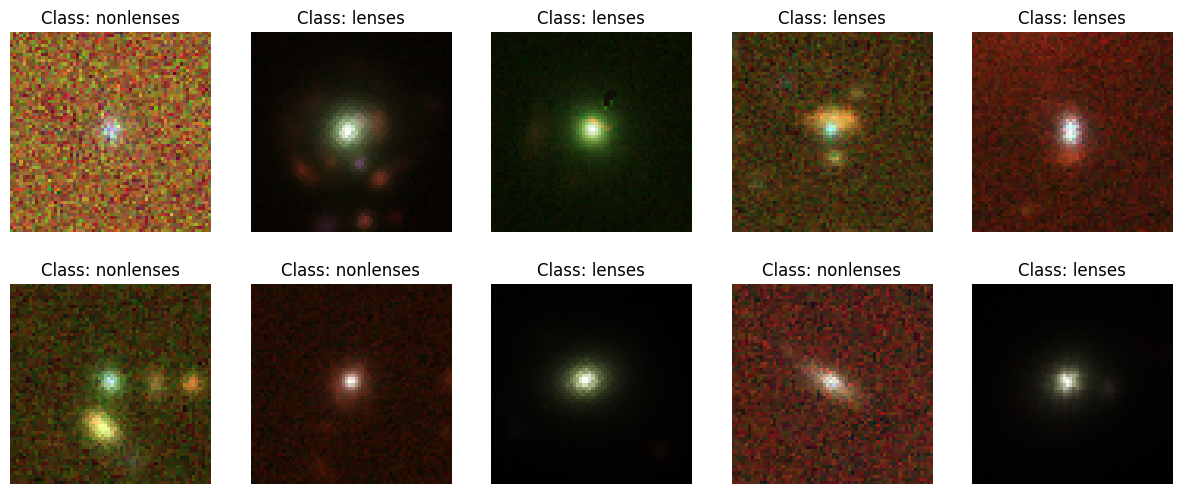

In [50]:
X, y = next(iter(trainLoader))

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

for i in range(10):
    ax[i//5][i%5].imshow(X[i].numpy().squeeze().transpose((1, 2, 0)))
    ax[i//5][i%5].set_title(f"Class: {reverseclasses[y[i].item()]}")
    ax[i//5][i%5].axis('off')

In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, out_features=1, bias=True)
model.to(device)

lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [52]:
def trainModel(model, lossfn, optimizer, iteration):
    epochs = iteration

    trainAcc, trainLoss = [], []

    iteration_count = 0
    total_iterations = len(trainLoader) * epochs

    with tqdm(total=total_iterations, desc="Training Progress") as pbar:

        for _ in range(epochs):
            model.train()
            batchAcc, batchLoss = [], []

            for X, y in trainLoader:
                X, y = X.to(device), y.to(device)
                yHat = model(X)
                loss = lossfn(yHat.squeeze(), y.float())

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                batchLoss.append(loss.item())

                predictions = (torch.sigmoid(yHat) > 0.5).float()
                matches = predictions == y
                matchNumeric = matches.float().detach()
                accuracy = 100 * torch.mean(matchNumeric)
                batchAcc.append(accuracy.item())

                iteration_count += 1

                if iteration_count % 200 == 0:
                    avg_train_loss = np.mean(batchLoss)
                    avg_train_acc = np.mean(batchAcc)
                    trainLoss.append(avg_train_loss)
                    trainAcc.append(avg_train_acc)
                    pbar.set_postfix_str(f"Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.2f}%")
                pbar.update(1)

    checkpoint = {
        "weights": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, "task_2_weights.pth")

    return trainLoss, trainAcc, model

In [53]:
trainLoss, trainAcc, model = trainModel(model, lossfn, optimizer, iteration=30)

Training Progress: 100%|██████████| 2940/2940 [00:39<00:00, 74.89it/s, Loss: 0.0167, Acc: 51.75%]
